# Tutorial [Raytracing em um final de semana](https://raytracing.github.io/books/RayTracingInOneWeekend.html#rays,asimplecamera,andbackground)

Observações: 

- As **etapas 1 e 2** estão implementadas no diretório **Atividade 01**

- A **etapa 3** está implementada em **Atividade 02**

- A **etapa 4.1** está implementada em **Ray.py** no mesmo repositório

## Importações

In [1]:
import sys
import os

import numpy as np
from tqdm import tqdm

sys.path.append(os.path.abspath(os.path.join('..')))

from Ray import Ray
from Atividade02.src.vectorized.Vec3 import Vec3, Point3, Color
from Atividade01.src.ImageIO import ImageWriter
from Atividade01.src.Image import Image

## 4.2 Sending Rays Into the scene 

In [2]:
aspect_ratio = 16.0 / 9.0
image_width = 400

image_height = int(image_width / aspect_ratio)
if image_height < 1:
    image_height = 1

viewport_height = 2.0
viewport_width = viewport_height * (image_width / image_height)
# OBS: viewport_width: não está usando a variável aspect_ratio, pois a variável aspect_ratio é a proporção ideal da imagem, porém, arredondamos image_height para inteiro, podendo assim perder um pouco de precisão na proporção da imagem.


  0%|          | 0/225 [00:00<?, ?it/s]

100%|██████████| 225/225 [00:08<00:00, 25.51it/s]


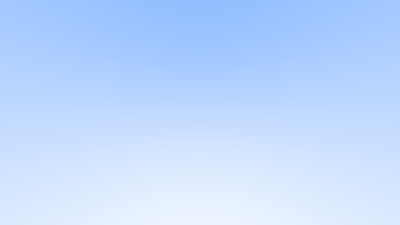

In [3]:
def ray_color(ray: Ray):
    unit_direction = ray.direction.unit_vector()
    a = 0.5 * (unit_direction.y + 1.0)
    return (1.0 - a) * Color([1.0, 1.0, 1.0]) + a * Color([0.5, 0.7, 1.0])

def raytrace_pipeline(filename: str):
    aspect_ratio = 16.0 / 9.0
    image_width = 400

    image_height = int(image_width / aspect_ratio)
    if image_height < 1:
        image_height = 1

    viewport_height = 2.0
    viewport_width = viewport_height * (image_width / image_height)
    
    focal_length = 1.0
    camera_center = Point3([0, 0, 0])

    viewport_u = Vec3([viewport_width, 0, 0])
    viewport_v = Vec3([0, -viewport_height, 0])

    pixel_delta_u = viewport_u / image_width
    pixel_delta_v = viewport_v / image_height

    # If pixels are spaced the same distance horizontally as they are vertically, the viewport that bounds them will have the same aspect ratio as the rendered image.
    # Como estamos definindo o viewport para ter o mesmo aspect ratio da imagem (quantidade de pixels), então, os pixels terão o mesmo espaçamento horizontal e vertical.

    viewport_upper_left = camera_center - Vec3([0, 0, focal_length]) - (viewport_u / 2) - (viewport_v / 2)
    pixel00_loc = viewport_upper_left + 0.5 * (pixel_delta_u + pixel_delta_v)
    # Precisa adicionar 0,5 da distancia de separação dos pixels. O canto esquerdo do viewport não é o mesmo que o ponto 0,0 da imagem. O viewport precisa ter uma borda de 0,5 espaçamento de pixel para cada lado.


    # CRIAR MATRIZ
    image = Image(image_width, image_height)
    for j in tqdm(range(image_height)):
        for i in range(image_width):
            pixel_center = pixel00_loc + (i * pixel_delta_u) + (j * pixel_delta_v)
            ray_direction = pixel_center - camera_center
            ray = Ray(camera_center, ray_direction)

            pixel_color = ray_color(ray)
            image[j, i] = pixel_color

    img_writer = ImageWriter(image)
    img_writer.save(filename)
    display(img_writer.image)

raytrace_pipeline('1-degrade-raytrace.png')
# A imagem sairá com degradê para os dois lados, pois está utilizando o vetor unidade, e não o próprio y diretamente
# Logo, as outras coordenadas (x e z) influenciam no vetor unidade, fazendo com que o y não seja o unico vetor que influencia na cor.

## 5.2 Creating Our First Raytraced Image

100%|██████████| 225/225 [00:10<00:00, 22.04it/s]


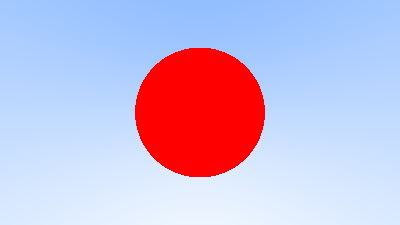

In [4]:
def hit_sphere(center: Point3, radius: float, ray: Ray):
    oc = ray.origin - center
    a = ray.direction.dot(ray.direction)
    b = 2 * oc.dot(ray.direction)
    c = oc.dot(oc) - radius ** 2

    discriminant = b ** 2 - 4 * a * c
    return discriminant >= 0

def ray_color(ray: Ray):
    # Se acertar a esfera, pinta de vermelho
    if hit_sphere(Point3([0, 0, -1]), 0.5, ray):
        return Color([1, 0, 0])
    
    # Se não, pinta com o fundo (degradê)
    unit_direction = ray.direction.unit_vector()
    a = 0.5 * (unit_direction.y + 1.0)
    return (1.0 - a) * Color([1.0, 1.0, 1.0]) + a * Color([0.5, 0.7, 1.0])

raytrace_pipeline('2-first-sphere.png')

## 6.1 Shading with Surface Normals

100%|██████████| 225/225 [00:10<00:00, 21.03it/s]


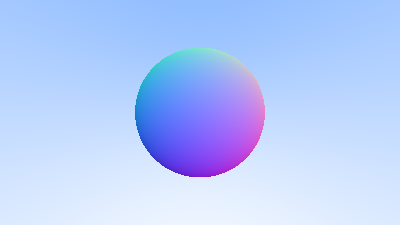

In [5]:
def hit_sphere(center: Point3, radius: float, ray: Ray):
    oc = ray.origin - center
    a = ray.direction.dot(ray.direction)
    b = 2 * oc.dot(ray.direction)
    c = oc.dot(oc) - radius ** 2

    discriminant = b ** 2 - 4 * a * c

    if discriminant < 0:
        return -1
    else:
        return (-b -np.sqrt(discriminant)) / (2.0 * a)

def ray_color(ray: Ray):
    # Se acertar a esfera, pinta de vermelho
    t = hit_sphere(Point3([0, 0, -1]), 0.5, ray)
    if t > 0:
        normal = (ray.at(t) - Vec3([0, 0, -1])).unit_vector()
        return 0.5 * Color([normal.x + 1, normal.y + 1, normal.z + 1])
    
    # Se não, pinta com o fundo (degradê)
    unit_direction = ray.direction.unit_vector()
    a = 0.5 * (unit_direction.y + 1.0)
    return (1.0 - a) * Color([1.0, 1.0, 1.0]) + a * Color([0.5, 0.7, 1.0])

raytrace_pipeline('3-sphere-with-normals.png')

## 6.2 Simplifying the Ray-Sphere Intersection Code

100%|██████████| 225/225 [00:10<00:00, 20.73it/s]


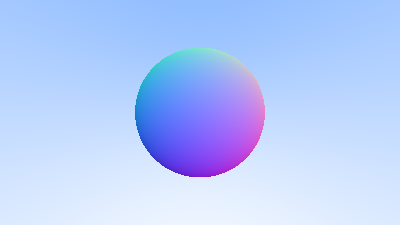

In [6]:
def hit_sphere(center: Point3, radius: float, ray: Ray):
    oc = ray.origin - center
    a = ray.direction.squared_length()
    half_b = oc.dot(ray.direction)
    c = oc.dot(oc) - radius ** 2

    discriminant = half_b ** 2 - a * c

    if discriminant < 0:
        return -1
    else:
        return (-half_b -np.sqrt(discriminant)) / a

raytrace_pipeline('4-simplified-sphere.png')

## 6.3 An Abstraction for Hittable Objects

In [7]:

class HitRecord:

    def __init__(self, p: Point3, normal: Vec3, t: float):
        self.p = p
        self.normal = normal
        self.t = t


class Hittable:

    def hit(self, ray: Ray, t_min: float, t_max: float) -> "tuple[bool, HitRecord]":
        raise NotImplementedError('Esse método método deve ser implementado na classe filha.')


class Sphere(Hittable):

    def __init__(self, center: Point3, radius: float):
        self.__center = center
        self.__radius = radius
    
    @property
    def center(self):
        return self.__center
    
    @property
    def radius(self):
        return self.__radius

    def hit(self, ray: Ray, t_min: float, t_max: float) -> "tuple[bool, HitRecord]":
        oc = ray.origin - self.center
        a = ray.direction.squared_length()
        half_b = oc.dot(ray.direction)
        c = oc.dot(oc) - self.radius ** 2

        discriminant = half_b ** 2 - a * c

        if discriminant < 0:
            return False, None
        else:
            root = np.sqrt(discriminant)
            t = (-half_b - root) / a
            if t < t_min or t > t_max:
                t = (-half_b + root) / a
                if t < t_min or t > t_max:
                    return False, None
            
            p = ray.at(t)
            normal = (p - self.center) / self.radius
            return True, HitRecord(p, normal, t)

## 6.4 Front Faces Versus Back Faces

In [8]:
class HitRecord:

    def __init__(self, p: Point3, normal: Vec3, t: float, ray: Ray):
        self.p = p
        self.t = t
        self.set_normal(normal, ray)
    
    def set_normal(self, outward_normal: Vec3, ray: Ray):
        self.front_face = ray.direction.dot(outward_normal) < 0
        self.normal = outward_normal if self.front_face else -outward_normal


class Sphere(Hittable):

    def __init__(self, center: Point3, radius: float):
        self.__center = center
        self.__radius = radius
    
    @property
    def center(self):
        return self.__center
    
    @property
    def radius(self):
        return self.__radius

    def hit(self, ray: Ray, t_min: float, t_max: float) -> "tuple[bool, HitRecord]":
        oc = ray.origin - self.center
        a = ray.direction.squared_length()
        half_b = oc.dot(ray.direction)
        c = oc.dot(oc) - self.radius ** 2

        discriminant = half_b ** 2 - a * c

        if discriminant < 0:
            return False, None
        else:
            root = np.sqrt(discriminant)
            t = (-half_b - root) / a
            if t < t_min or t > t_max:
                t = (-half_b + root) / a
                if t < t_min or t > t_max:
                    return False, None
            
            p = ray.at(t)
            normal = (p - self.center) / self.radius
            return True, HitRecord(p, normal, t, ray)

## 6.5 A List of Hittable Objects

In [9]:
class HittableList:
    
    def __init__(self):
        self.objects: list[Hittable] = []
    
    def add(self, obj: Hittable):
        self.objects.append(obj)
    
    def clear(self):
        self.objects.clear()
    
    def hit(self, ray: Ray, t_min: float, t_max: float) -> "tuple[bool, HitRecord]":
        hit_anything = False
        closest_so_far = t_max
        for obj in self.objects:
            hit, rec = obj.hit(ray, t_min, closest_so_far)
            if hit:
                hit_anything = True
                closest_so_far = rec.t
                hit_record = rec
        
        if hit_anything:
            return True, hit_record
        else:
            return False, None

## 6.7 Common Constants and Utility Functions

In [10]:
infinity = np.inf
pi = np.pi

def degrees_to_radians(degrees: float):
    return degrees * pi / 180.0

100%|██████████| 225/225 [00:12<00:00, 18.31it/s]


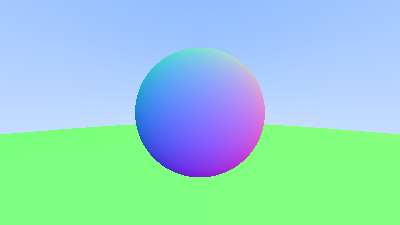

In [11]:
def ray_color(ray: Ray, world: HittableList) -> Color:
    hit, rec = world.hit(ray, 0, infinity)
    if hit:
        return Color((0.5 * (rec.normal + Color([1, 1, 1]))).vec)
    
    unit_direction = ray.direction.unit_vector()
    t = 0.5 * (unit_direction.y + 1.0)
    return (1.0 - t) * Color([1.0, 1.0, 1.0]) + t * Color([0.5, 0.7, 1.0])

def raytrace_pipeline(filename: str):
    aspect_ratio = 16.0 / 9.0
    image_width = 400

    image_height = int(image_width / aspect_ratio)
    if image_height < 1:
        image_height = 1

    world = HittableList()

    world.add(Sphere(Point3([0, 0, -1]), 0.5))
    world.add(Sphere(Point3([0, -100.5, -1]), 100))


    viewport_height = 2.0
    viewport_width = viewport_height * (image_width / image_height)
    focal_length = 1.0
    camera_center = Point3([0, 0, 0])

    viewport_u = Vec3([viewport_width, 0, 0])
    viewport_v = Vec3([0, -viewport_height, 0])

    pixel_delta_u = viewport_u / image_width
    pixel_delta_v = viewport_v / image_height

    # If pixels are spaced the same distance horizontally as they are vertically, the viewport that bounds them will have the same aspect ratio as the rendered image.
    # Como estamos definindo o viewport para ter o mesmo aspect ratio da imagem (quantidade de pixels), então, os pixels terão o mesmo espaçamento horizontal e vertical.

    viewport_upper_left = camera_center - Vec3([0, 0, focal_length]) - (viewport_u / 2) - (viewport_v / 2)
    pixel00_loc = viewport_upper_left + 0.5 * (pixel_delta_u + pixel_delta_v)
    # Precisa adicionar 0,5 da distancia de separação dos pixels. O canto esquerdo do viewport não é o mesmo que o ponto 0,0 da imagem. O viewport precisa ter uma borda de 0,5 espaçamento de pixel para cada lado.


    # CRIAR MATRIZ
    image = Image(image_width, image_height)
    for j in tqdm(range(image_height)):
        for i in range(image_width):
            pixel_center = pixel00_loc + (i * pixel_delta_u) + (j * pixel_delta_v)
            ray_direction = pixel_center - camera_center
            ray = Ray(camera_center, ray_direction)

            pixel_color = ray_color(ray, world)
            image[j, i] = pixel_color

    img_writer = ImageWriter(image)
    img_writer.save(filename)
    display(img_writer.image)

raytrace_pipeline('5-first-world.png')
# A imagem sairá com degradê para os dois lados, pois está utilizando o vetor unidade, e não o próprio y diretamente
# Logo, as outras coordenadas (x e z) influenciam no vetor unidade, fazendo com que o y não seja o unico vetor que influencia na cor.

## 6.8 An Interval Class

In [12]:
class Interval:

    def __init__(self, min: float, max: float):
        self.min = min
        self.max = max

    def __contains__(self, value: float):
        return self.min <= value <= self.max
    
    def surrounds(self, value: float):
        return self.min <= value <= self.max

In [13]:
class Hittable:

    def hit(self, ray: Ray, t_interval: Interval) -> "tuple[bool, HitRecord]":
        raise NotImplementedError('Esse método método deve ser implementado na classe filha.')

In [14]:
class Sphere(Hittable):

    def __init__(self, center: Point3, radius: float):
        self.__center = center
        self.__radius = radius
    
    @property
    def center(self):
        return self.__center
    
    @property
    def radius(self):
        return self.__radius

    def hit(self, ray: Ray, t_interval: Interval) -> "tuple[bool, HitRecord]":
        oc = ray.origin - self.center
        a = ray.direction.squared_length()
        half_b = oc.dot(ray.direction)
        c = oc.dot(oc) - self.radius ** 2

        discriminant = half_b ** 2 - a * c

        if discriminant < 0:
            return False, None
        else:
            root = np.sqrt(discriminant)
            t = (-half_b - root) / a
            if t not in t_interval:
                t = (-half_b + root) / a
                if t not in t_interval:
                    return False, None
            
            p = ray.at(t)
            normal = (p - self.center) / self.radius
            return True, HitRecord(p, normal, t, ray)

In [15]:
class HittableList:
    
    def __init__(self):
        self.objects: list[Hittable] = []
    
    def add(self, obj: Hittable):
        self.objects.append(obj)
    
    def clear(self):
        self.objects.clear()
    
    def hit(self, ray: Ray, interval: Interval) -> "tuple[bool, HitRecord]":
        hit_anything = False
        closest_so_far = interval.max
        for obj in self.objects:
            hit, rec = obj.hit(ray, Interval(interval.min, closest_so_far))
            if hit:
                hit_anything = True
                closest_so_far = rec.t
                hit_record = rec
        
        if hit_anything:
            return True, hit_record
        else:
            return False, None

100%|██████████| 225/225 [00:13<00:00, 16.35it/s]


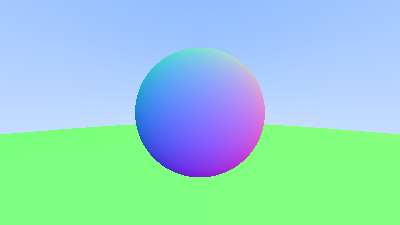

In [16]:
def ray_color(ray: Ray, world: HittableList) -> Color:
    hit, rec = world.hit(ray, Interval(0, infinity))
    if hit:
        return Color((0.5 * (rec.normal + Color([1, 1, 1]))).vec)
    
    unit_direction = ray.direction.unit_vector()
    t = 0.5 * (unit_direction.y + 1.0)
    return (1.0 - t) * Color([1.0, 1.0, 1.0]) + t * Color([0.5, 0.7, 1.0])

raytrace_pipeline('6-first-world-with-interval.png')

## 7 Moving Camera Code Into Its Own Class

In [17]:
class Camera:

    def initialize(self):
        self.aspect_ratio = 16.0 / 9.0
        self.image_width = 400

        self.image_height = int(image_width / aspect_ratio)
        if self.image_height < 1:
            self.image_height = 1

        self.viewport_height = 2.0
        self.viewport_width = self.viewport_height * (image_width / image_height)
        self.focal_length = 1.0
        self.camera_center = Point3([0, 0, 0])

        self.viewport_u = Vec3([self.viewport_width, 0, 0])
        self.viewport_v = Vec3([0, -self.viewport_height, 0])

        self.pixel_delta_u = self.viewport_u / self.image_width
        self.pixel_delta_v = self.viewport_v / self.image_height

        # If pixels are spaced the same distance horizontally as they are vertically, the viewport that bounds them will have the same aspect ratio as the rendered image.
        # Como estamos definindo o viewport para ter o mesmo aspect ratio da imagem (quantidade de pixels), então, os pixels terão o mesmo espaçamento horizontal e vertical.

        self.viewport_upper_left = self.camera_center - Vec3([0, 0, self.focal_length]) - (self.viewport_u / 2) - (self.viewport_v / 2)
        self.pixel00_loc = self.viewport_upper_left + 0.5 * (self.pixel_delta_u + self.pixel_delta_v)
        # Precisa adicionar 0,5 da distancia de separação dos pixels. O canto esquerdo do viewport não é o mesmo que o ponto 0,0 da imagem. O viewport precisa ter uma borda de 0,5 espaçamento de pixel para cada lado.

    def ray_color(self, ray: Ray, world: HittableList) -> Color:
        hit, rec = world.hit(ray, Interval(0, infinity))
        if hit:
            return Color((0.5 * (rec.normal + Color([1, 1, 1]))).vec)
        
        unit_direction = ray.direction.unit_vector()
        t = 0.5 * (unit_direction.y + 1.0)
        return (1.0 - t) * Color([1.0, 1.0, 1.0]) + t * Color([0.5, 0.7, 1.0])
    
    def render(self, world: HittableList, filename: str) -> Image:
        self.initialize()

        image = Image(self.image_width, self.image_height)
        for j in tqdm(range(self.image_height)):
            for i in range(self.image_width):
                self.pixel_center = self.pixel00_loc + (i * self.pixel_delta_u) + (j * self.pixel_delta_v)
                self.ray_direction = self.pixel_center - self.camera_center
                ray = Ray(self.camera_center, self.ray_direction)

                pixel_color = ray_color(ray, world)
                image[j, i] = pixel_color

        img_writer = ImageWriter(image)
        img_writer.save(filename)
        display(img_writer.image)
        
        return image

100%|██████████| 225/225 [00:14<00:00, 15.99it/s]


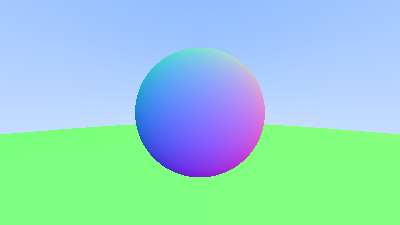

In [18]:
camera = Camera()

world = HittableList()
world.add(Sphere(Point3([0, 0, -1]), 0.5))
world.add(Sphere(Point3([0, -100.5, -1]), 100))

camera.render(world, '7-camera-class.png')